# Imports

In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


# Setup

### Set size of the figures

In [2]:
plt.rcParams["figure.figsize"] = (6,3.5)
plt.rcParams['figure.dpi'] = 600

### Set desired minimum bucket size

In [3]:
min_bucket_size = 30

### Define helper functions

In [4]:
def check_bucket_size(row):
    if row["count"] < min_bucket_size:
        return "indianred"
    return "steelblue"

def custom_rounding(row, base):
    max_frac_digits = 100
    for i in range(max_frac_digits):
        if round(base, -int(math.floor(math.log10(base))) + i) == base:
            frac_digits = -int(math.floor(math.log10(base))) + i
            break
    return round(round(row / base) * base, frac_digits)

# Simulations

### Raw aggregates

In [5]:
np.random.seed(0)
resting_heart_rate_aggregates = np.random.normal(loc=70, scale=8, size=10000)
df_raw = pd.DataFrame(data=resting_heart_rate_aggregates, columns=["value"])
df_raw["count"] = df_raw.groupby("value")["value"].transform("count")
df_raw["color"] = df_raw.apply(check_bucket_size, axis=1)

df_raw

,value,count,color
0,84.112419,1,indianred
1,73.201258,1,indianred
2,77.829904,1,indianred
3,87.927146,1,indianred
4,84.940464,1,indianred
...,...,...,...
9995,55.525746,1,indianred
9996,70.338871,1,indianred
9997,74.134977,1,indianred
9998,69.736634,1,indianred


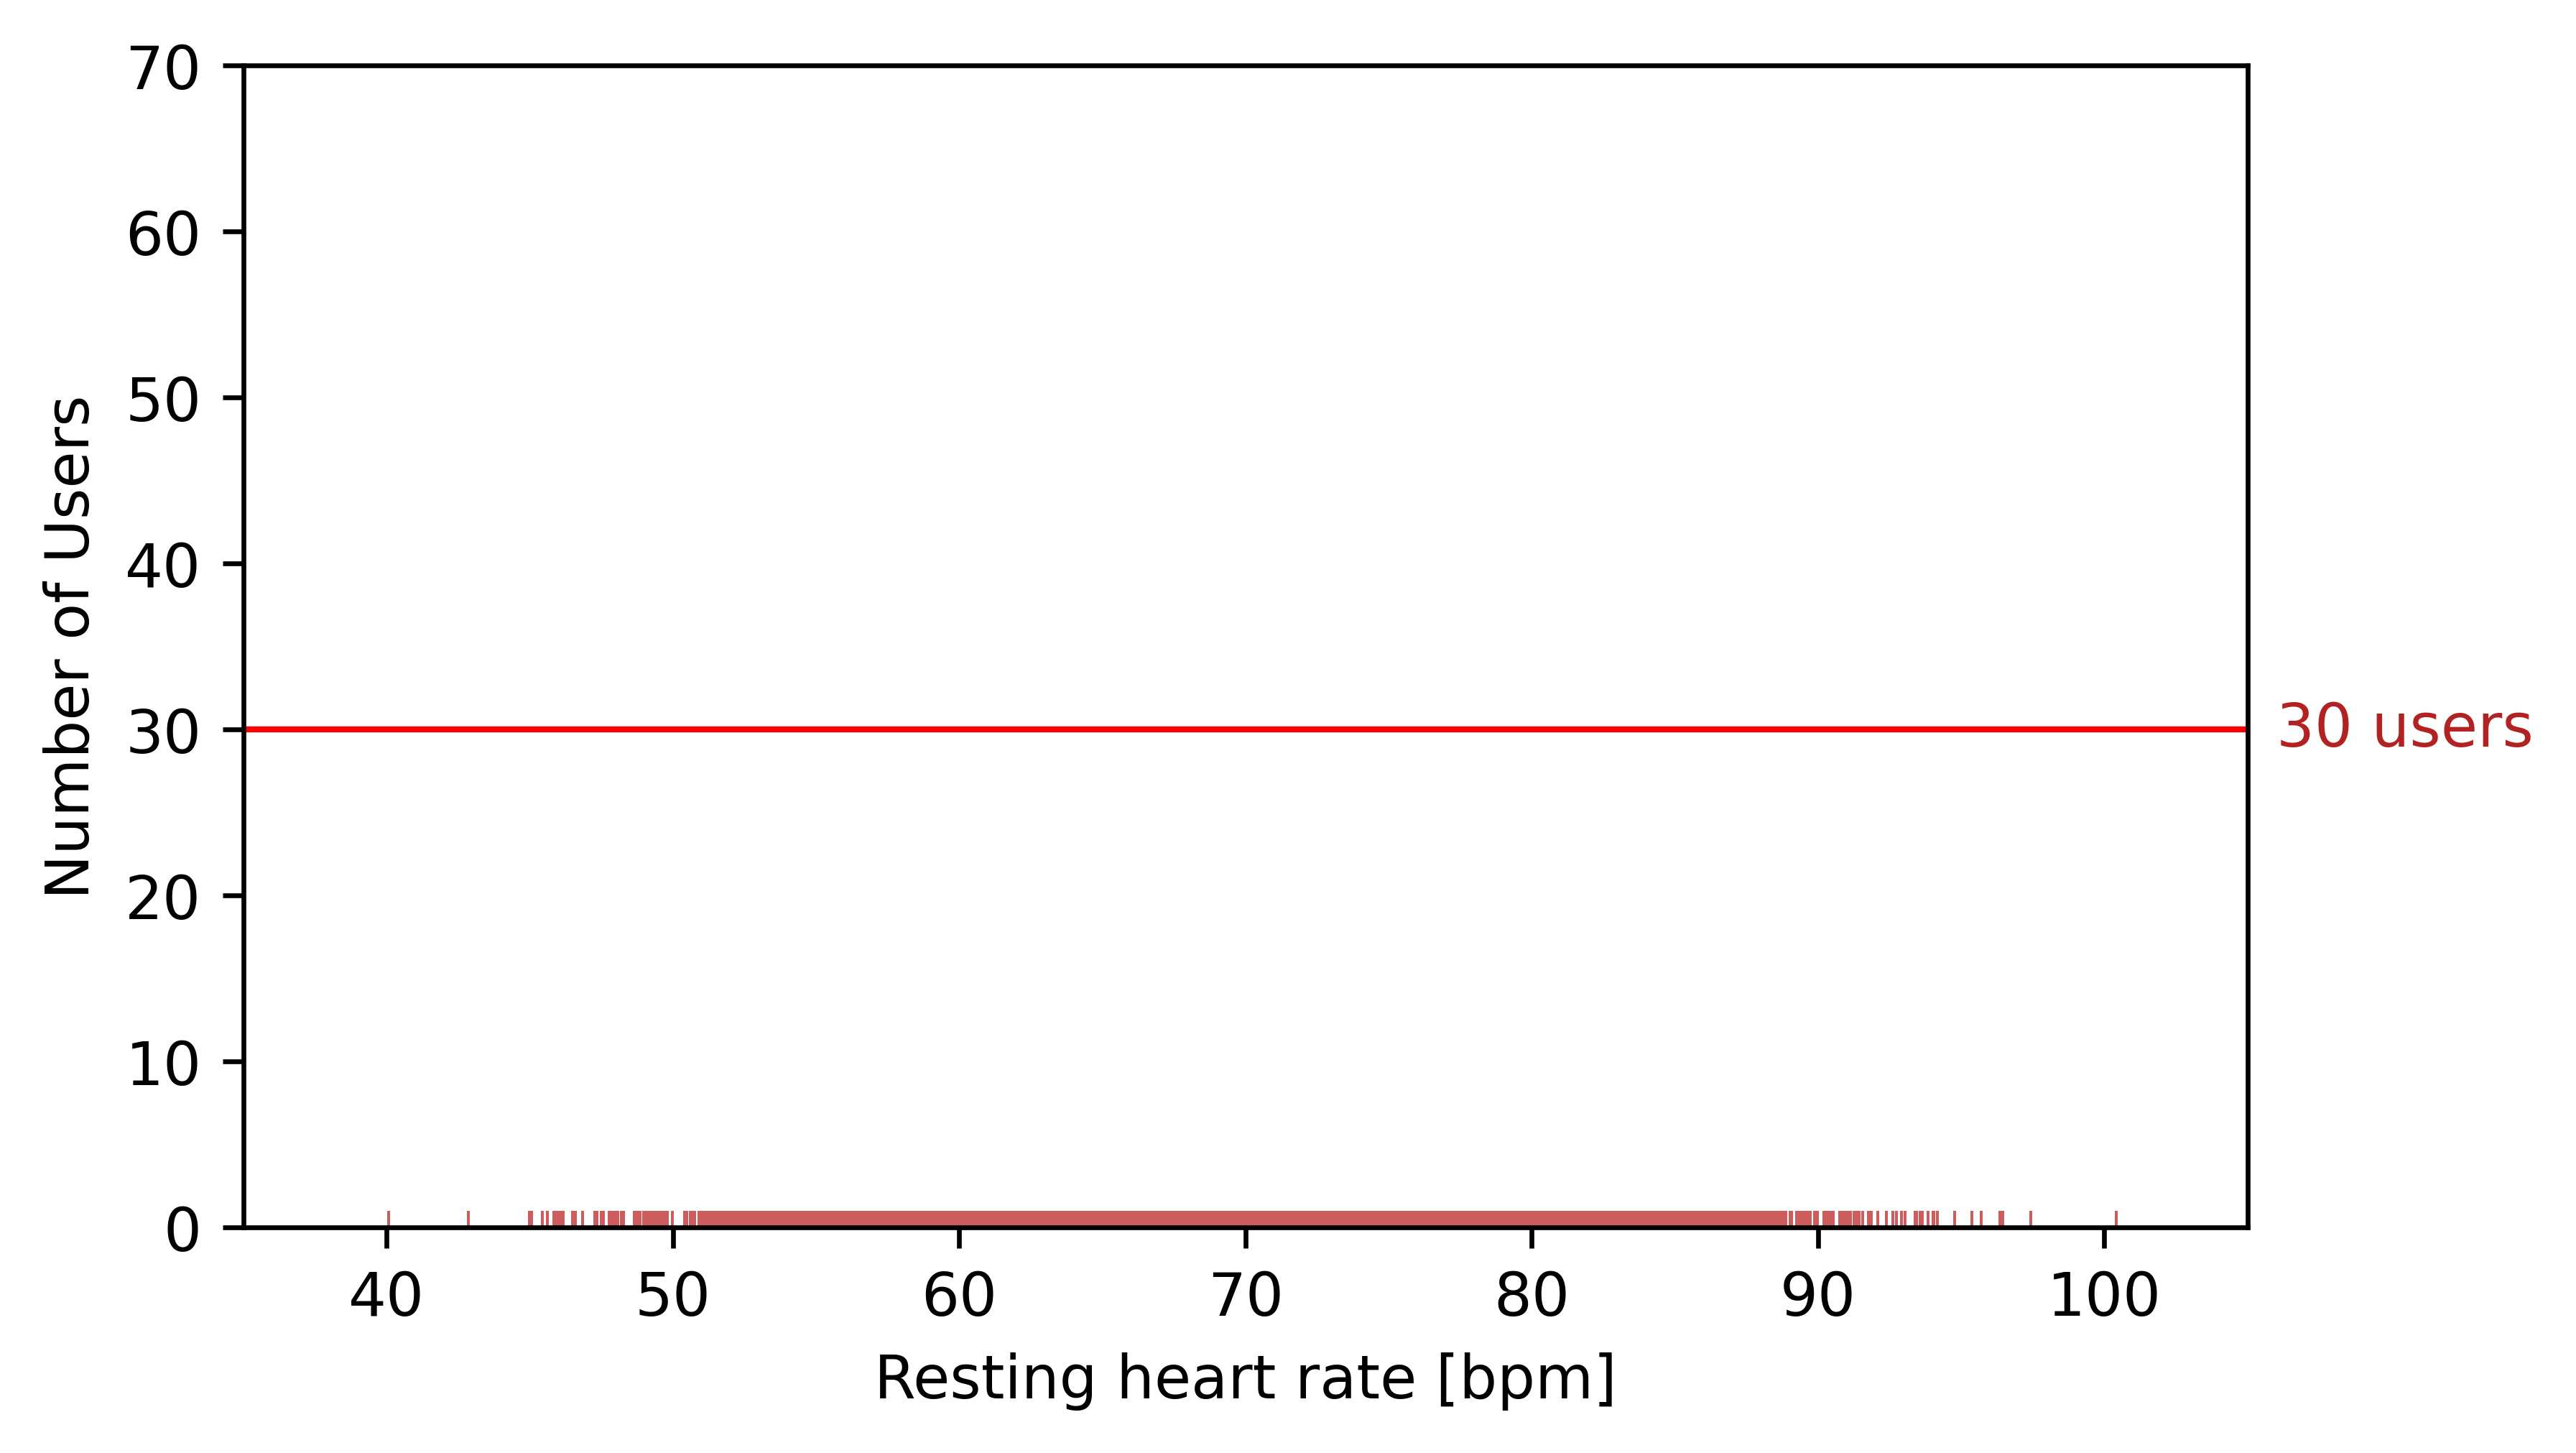

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=df_raw["value"], height=df_raw["count"], color=df_raw["color"], width=0.1)
ax.set_xlim(left=35, right=105)
ax.set_ylim(bottom=0, top=70)
ax.set_xlabel("Resting heart rate [bpm]")
ax.set_ylabel("Number of Users")
ax.text(x=106, y=29, s=f"{min_bucket_size} users", color="firebrick")
plt.plot([35, 105], [min_bucket_size, min_bucket_size], linewidth=1, color="red")
plt.savefig("histogram_raw", bbox_inches="tight")

plt.show()

### Rounding factor: 0.25

In [7]:
rounding_factor = 0.25
df_rounded_025 = pd.DataFrame(df_raw["value"])
df_rounded_025["value"] = df_rounded_025.apply(custom_rounding, args=(rounding_factor,), axis=1)
df_rounded_025["count"] = df_rounded_025.groupby("value")["value"].transform("count")
df_rounded_025["color"] = df_rounded_025.apply(check_bucket_size, axis=1)

df_rounded_025

,value,count,color
0,84.00,33,steelblue
1,73.25,133,steelblue
2,77.75,73,steelblue
3,88.00,9,indianred
4,85.00,10,indianred
...,...,...,...
9995,55.50,25,indianred
9996,70.25,133,steelblue
9997,74.25,114,steelblue
9998,69.75,141,steelblue


In [8]:
red_buckets_025 = df_rounded_025[df_rounded_025["count"]<min_bucket_size]
left_red_buckets_025 = red_buckets_025[red_buckets_025["value"]<((red_buckets_025["value"].max()+red_buckets_025["value"].min())/2)]
right_red_buckets_025 = red_buckets_025[red_buckets_025["value"]>=((red_buckets_025["value"].max()+red_buckets_025["value"].min())/2)]
last_left_red_025 = left_red_buckets_025["value"].max()
first_right_red_025 = right_red_buckets_025["value"].min()
left_cap_xlocation_025 = last_left_red_025 + rounding_factor
right_cap_xlocation_025 = first_right_red_025 - rounding_factor
left_cap_ylocation_025 = df_rounded_025.groupby(["value"]).mean(numeric_only=True)["count"][left_cap_xlocation_025]
right_cap_ylocation_025 = df_rounded_025.groupby(["value"]).mean(numeric_only=True)["count"][right_cap_xlocation_025]
left_cap_size_025 = df_rounded_025[df_rounded_025["value"]<=last_left_red_025].groupby(["value"]).mean(numeric_only=True)["count"].sum()
right_cap_size_025 = df_rounded_025[df_rounded_025["value"]>=first_right_red_025].groupby(["value"]).mean(numeric_only=True)["count"].sum()


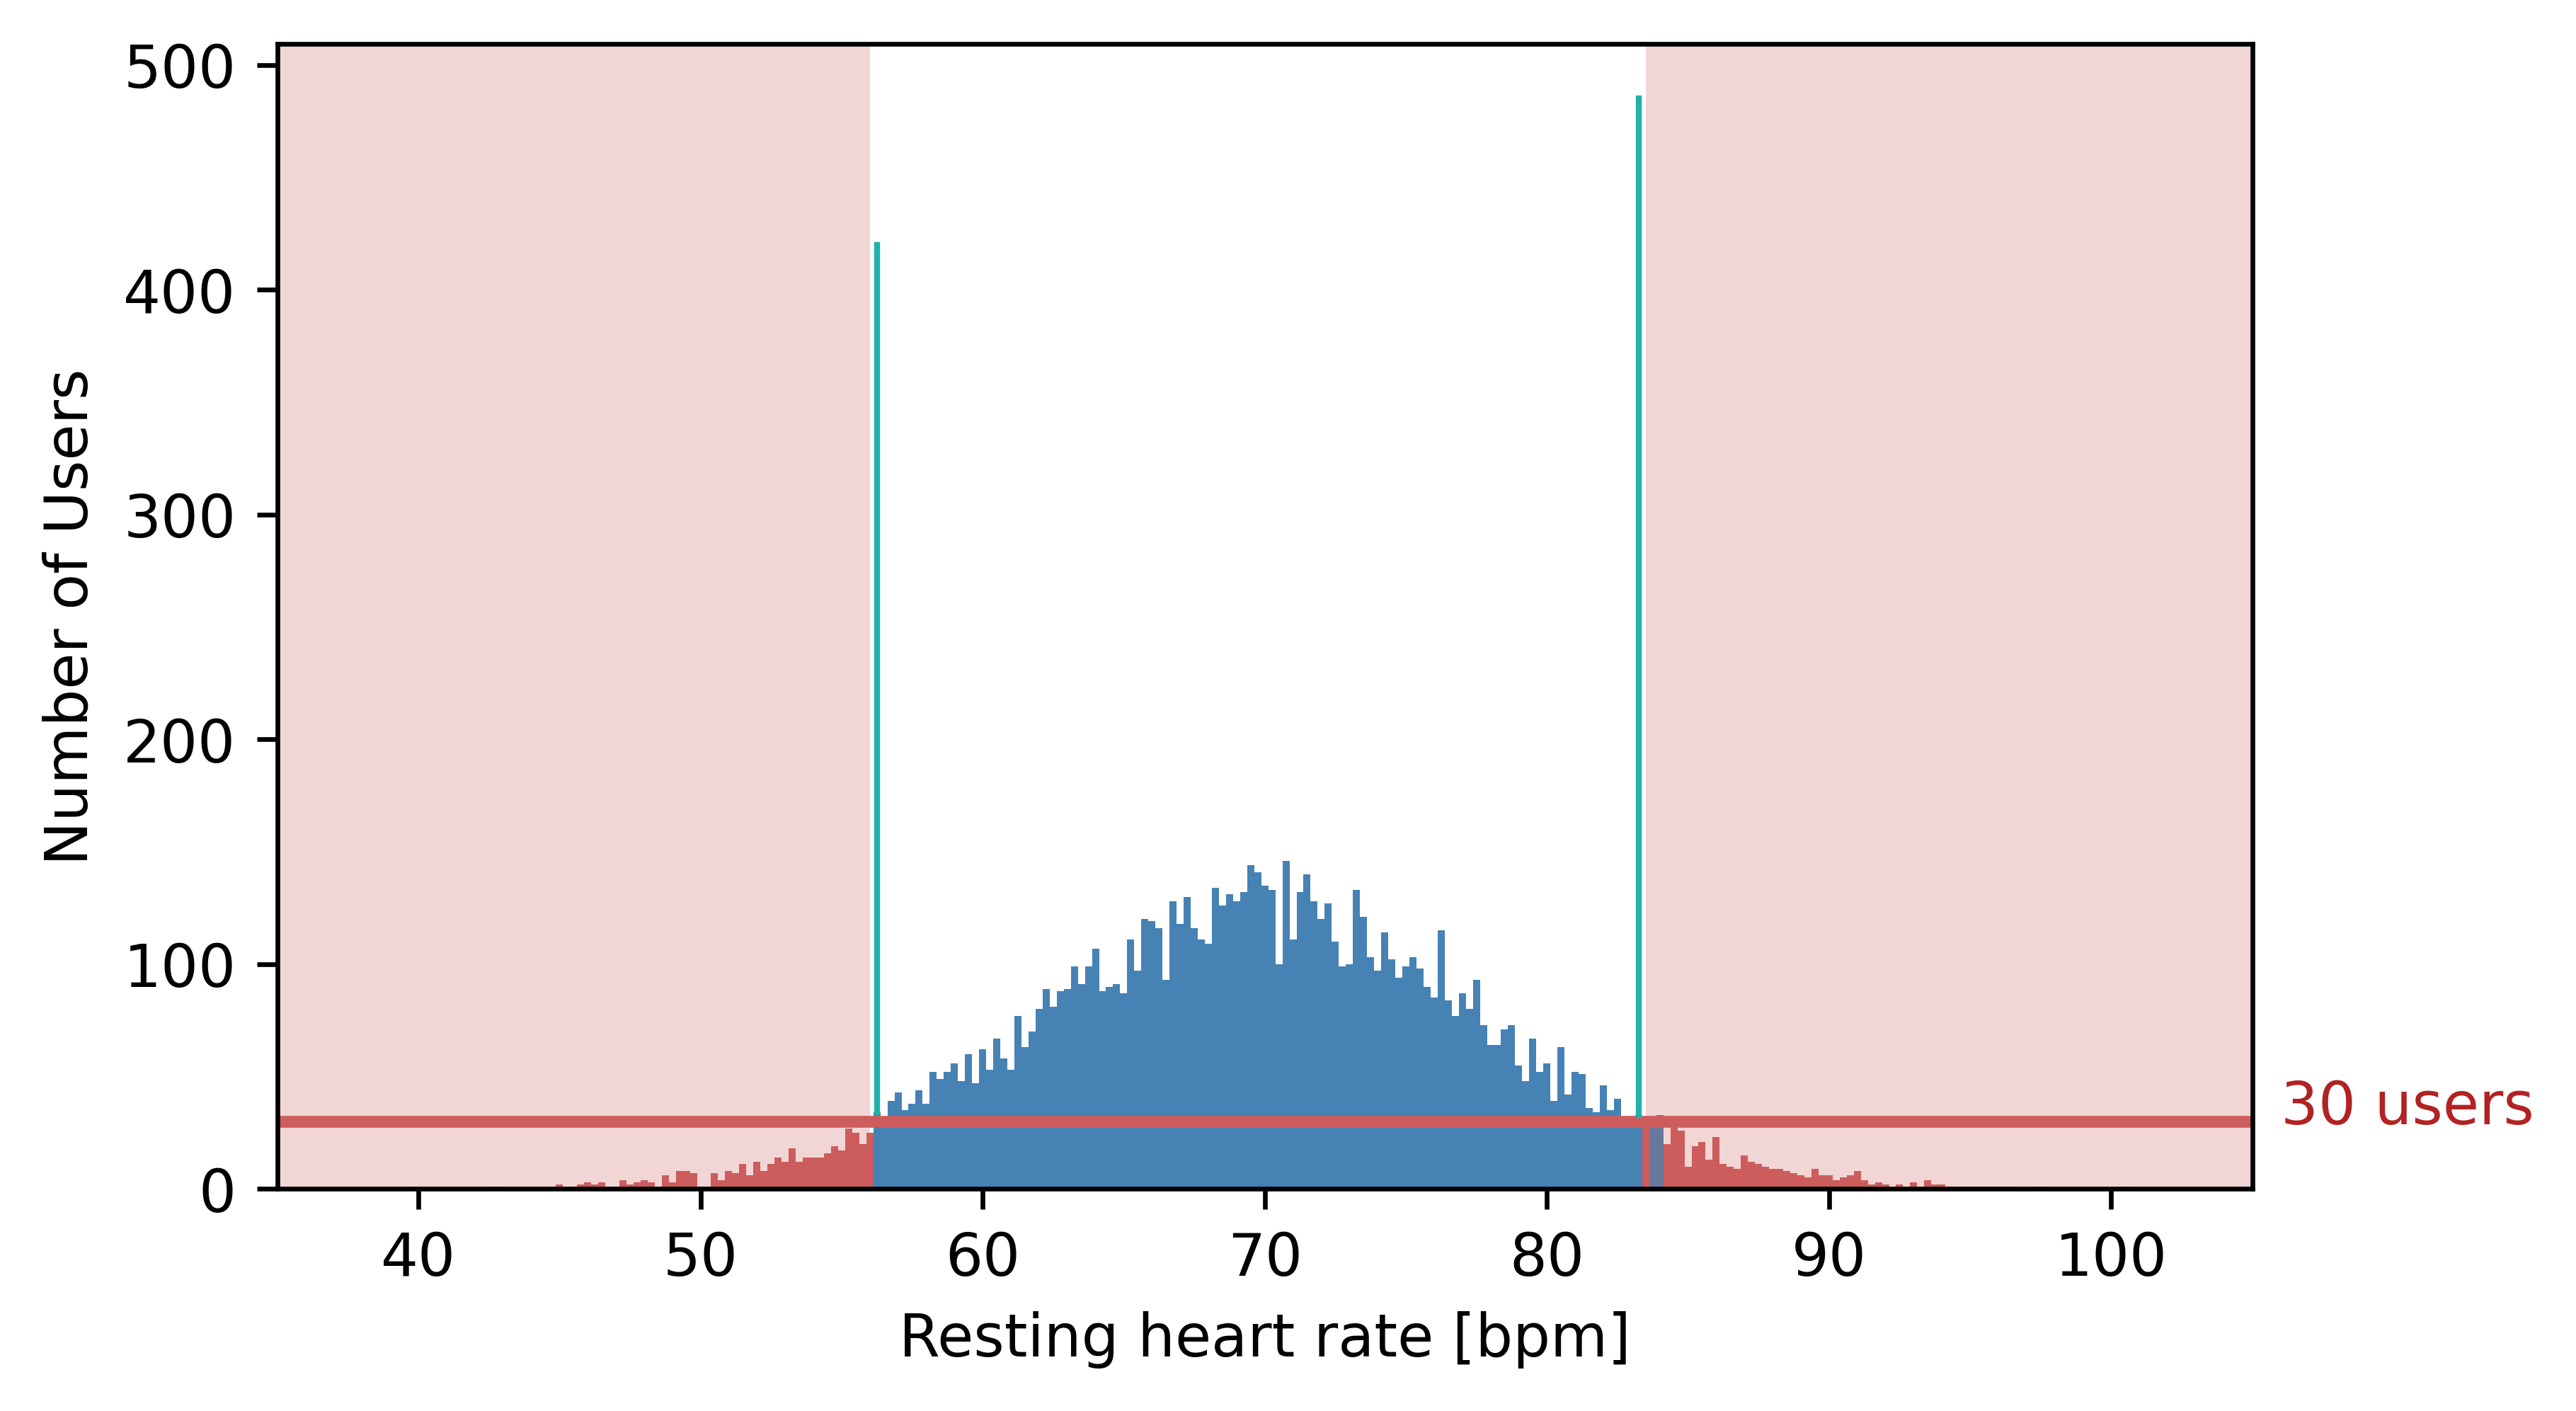

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=df_rounded_025["value"], height=df_rounded_025["count"], color=df_rounded_025["color"], width=0.25)
ax.set_xlim(left=35, right=105)
ax.set_xlabel("Resting heart rate [bpm]")
ax.set_ylabel("Number of Users")
plt.plot([35, 105], [min_bucket_size, min_bucket_size], linewidth=2, color="indianred")
ax.plot([left_cap_xlocation_025, left_cap_xlocation_025], [left_cap_ylocation_025, left_cap_ylocation_025+left_cap_size_025], linewidth=1, color="lightseagreen")
ax.plot([right_cap_xlocation_025, right_cap_xlocation_025], [right_cap_ylocation_025, right_cap_ylocation_025+right_cap_size_025], linewidth=1, color="lightseagreen")
ax.text(x=106, y=29, s=f"{min_bucket_size} users", color="firebrick")
ax.axvspan(0, last_left_red_025, facecolor='indianred', alpha=0.25)
ax.axvspan(first_right_red_025, 105, facecolor='indianred', alpha=0.25)
fig.savefig("histogram_025", bbox_inches="tight")

plt.show()

### Rounding factor: 1

In [10]:
rounding_factor = 1
df_rounded_1 = pd.DataFrame(df_raw["value"])
df_rounded_1["value"] = df_rounded_1.apply(custom_rounding, args=(rounding_factor,), axis=1)
df_rounded_1["count"] = df_rounded_1.groupby("value")["value"].transform("count")
df_rounded_1["color"] = df_rounded_1.apply(check_bucket_size, axis=1)

df_rounded_1

,value,count,color
0,84.0,114,steelblue
1,73.0,449,steelblue
2,78.0,280,steelblue
3,88.0,38,steelblue
4,85.0,78,steelblue
...,...,...,...
9995,56.0,104,steelblue
9996,70.0,533,steelblue
9997,74.0,423,steelblue
9998,70.0,533,steelblue


In [11]:
red_buckets_1 = df_rounded_1[df_rounded_1["count"]<min_bucket_size]
left_red_buckets_1 = red_buckets_1[red_buckets_1["value"]<((red_buckets_1["value"].max()+red_buckets_1["value"].min())/2)]
right_red_buckets_1 = red_buckets_1[red_buckets_1["value"]>=((red_buckets_1["value"].max()+red_buckets_1["value"].min())/2)]
last_left_red_1 = left_red_buckets_1["value"].max()
first_right_red_1 = right_red_buckets_1["value"].min()
left_cap_xlocation_1 = last_left_red_1 + rounding_factor
right_cap_xlocation_1 = first_right_red_1 - rounding_factor
left_cap_ylocation_1 = df_rounded_1.groupby(["value"]).mean(numeric_only=True)["count"][left_cap_xlocation_1]
right_cap_ylocation_1 = df_rounded_1.groupby(["value"]).mean(numeric_only=True)["count"][right_cap_xlocation_1]
left_cap_size_1 = df_rounded_025[df_rounded_1["value"]<=last_left_red_1].groupby(["value"]).mean(numeric_only=True)["count"].sum()
right_cap_size_1 = df_rounded_025[df_rounded_1["value"]>=first_right_red_1].groupby(["value"]).mean(numeric_only=True)["count"].sum()

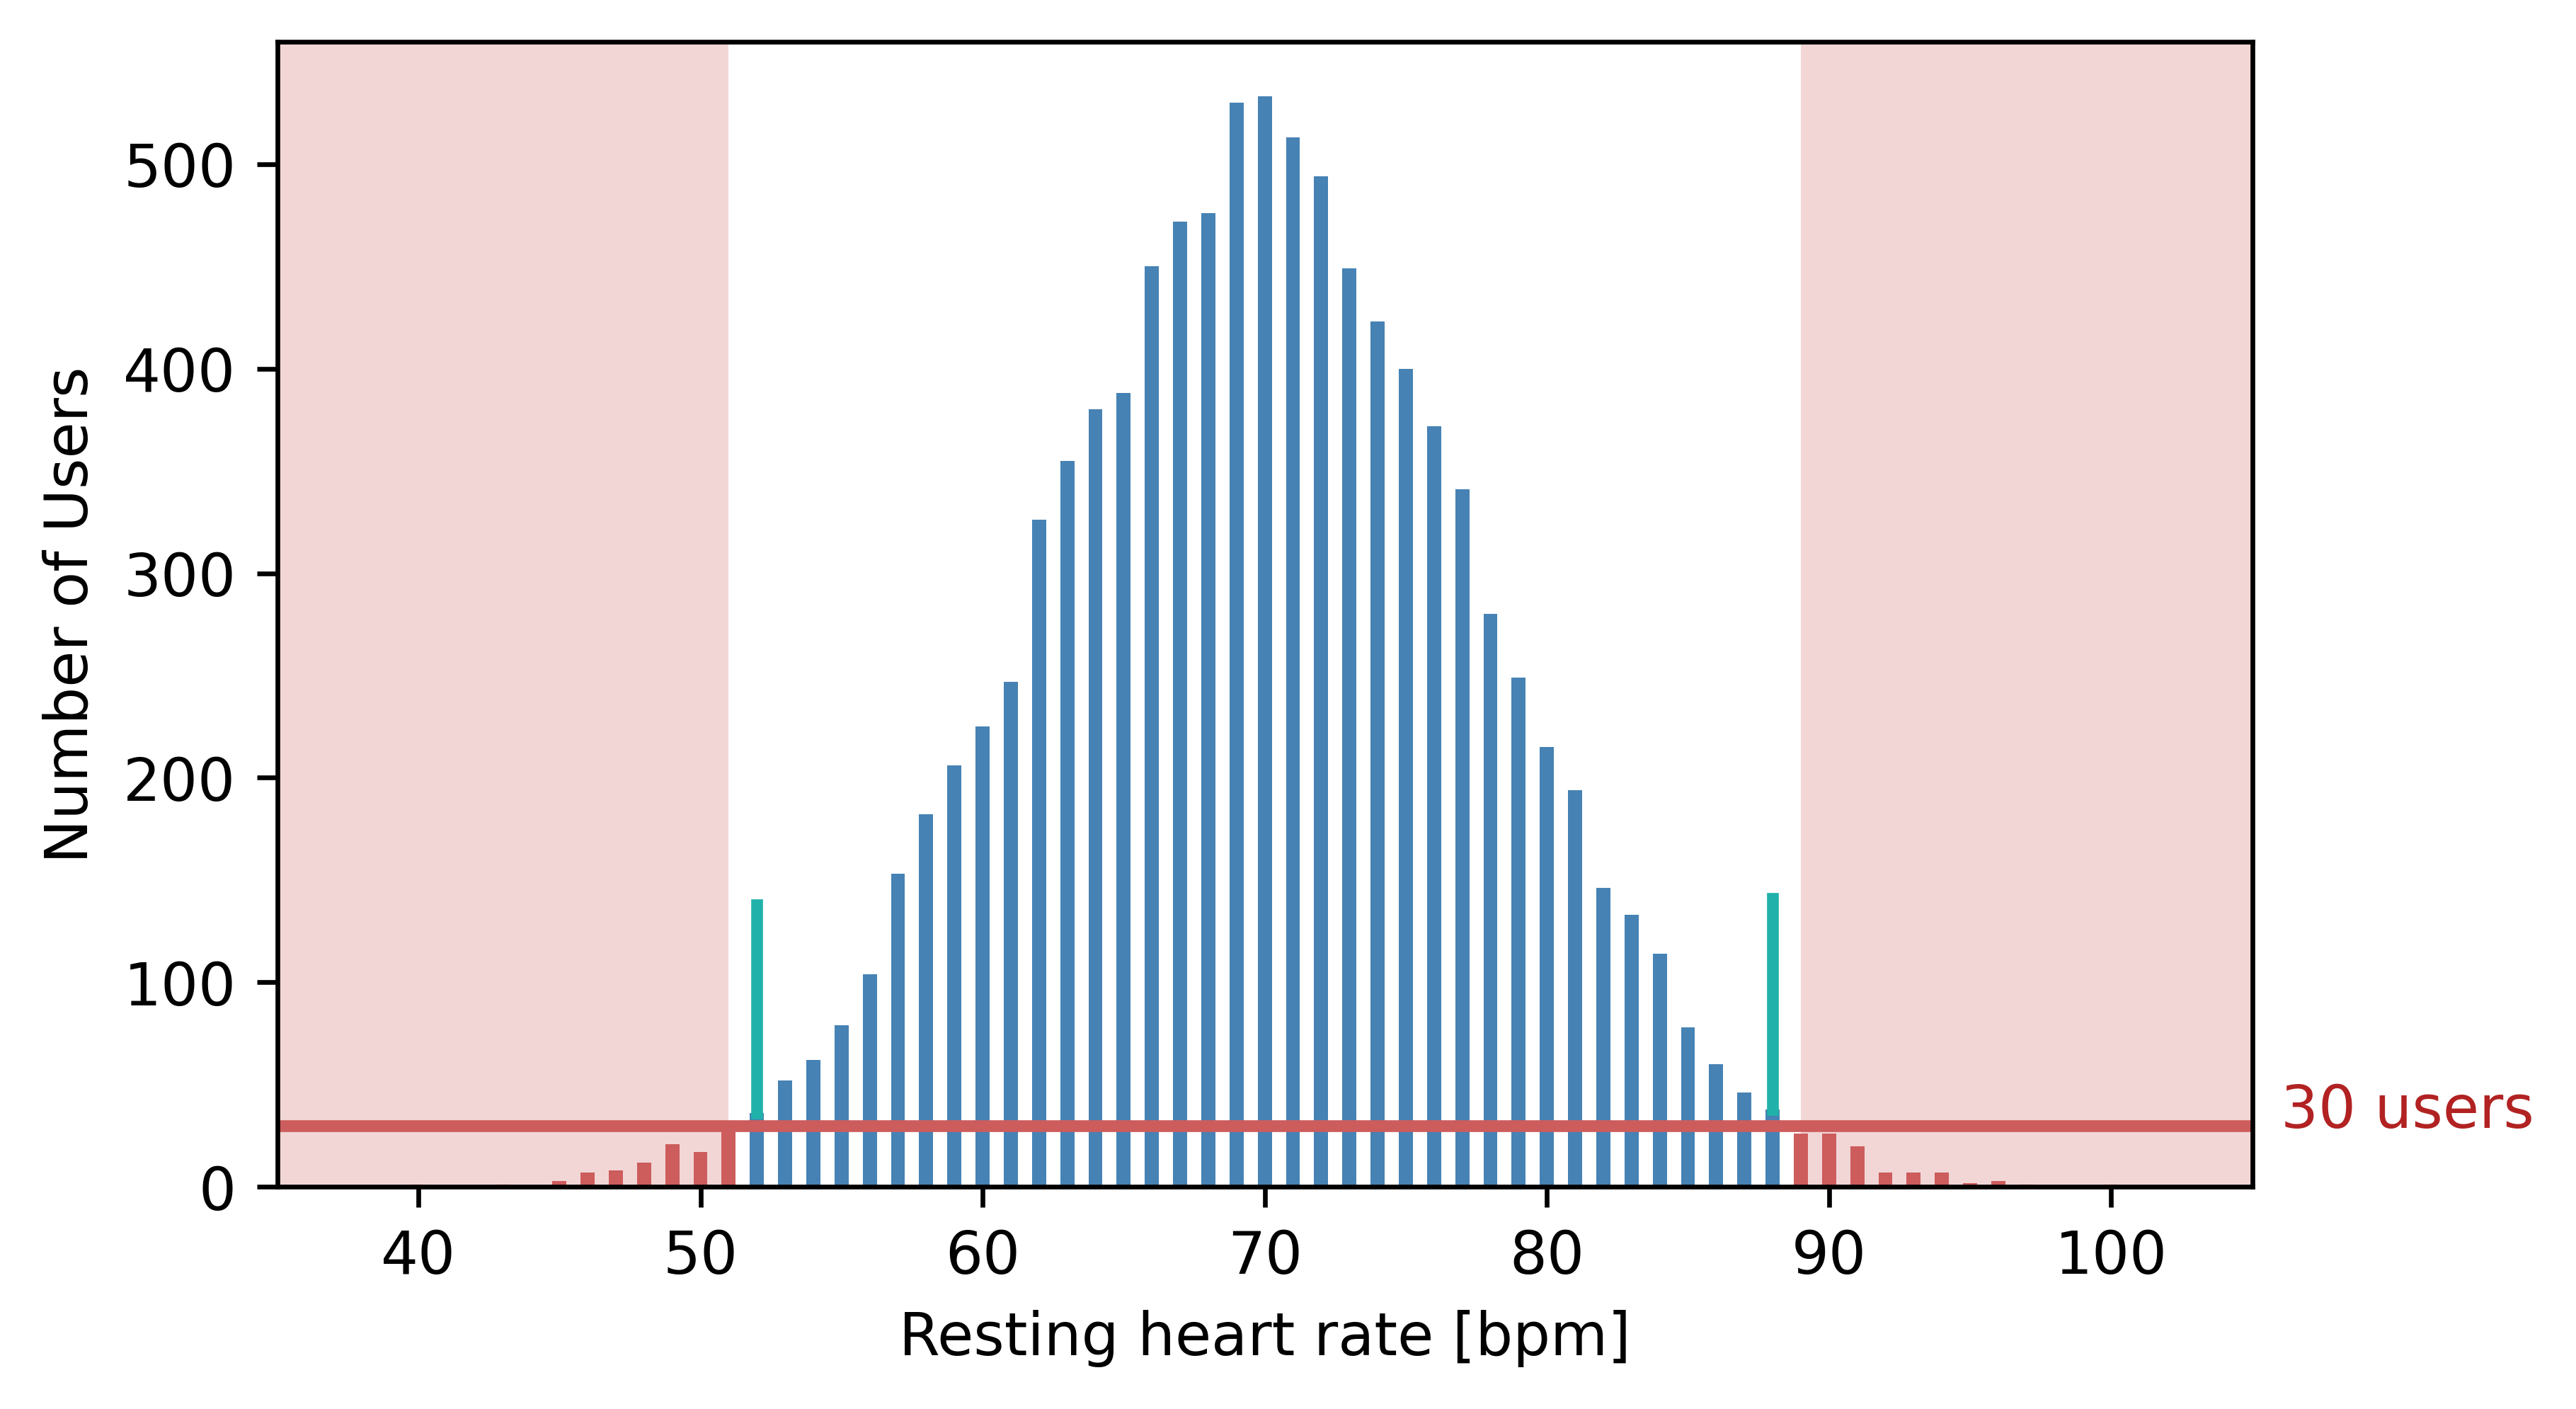

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=df_rounded_1["value"], height=df_rounded_1["count"], color=df_rounded_1["color"], width=0.5)
ax.set_xlim(left=35, right=105)
ax.set_xlabel("Resting heart rate [bpm]")
ax.set_ylabel("Number of Users")
plt.plot([35, 105], [min_bucket_size, min_bucket_size], linewidth=2, color="indianred")
ax.plot([left_cap_xlocation_1, left_cap_xlocation_1], [left_cap_ylocation_1, left_cap_ylocation_1+left_cap_size_1], linewidth=2, color="lightseagreen")
ax.plot([right_cap_xlocation_1, right_cap_xlocation_1], [right_cap_ylocation_1, right_cap_ylocation_1+right_cap_size_1], linewidth=2, color="lightseagreen")
ax.text(x=106, y=29, s=f"{min_bucket_size} users", color="firebrick")
ax.axvspan(0, last_left_red_1, facecolor='indianred', alpha=0.25)
ax.axvspan(first_right_red_1, 105, facecolor='indianred', alpha=0.25)
fig.savefig("histogram_1", bbox_inches="tight")

plt.show()

### Rounding factor: 2

In [13]:
rounding_factor = 2
df_rounded_2 = pd.DataFrame(df_raw["value"])
df_rounded_2["value"] = df_rounded_2.apply(custom_rounding, args=(rounding_factor,), axis=1)
df_rounded_2["count"] = df_rounded_2.groupby("value")["value"].transform("count")
df_rounded_2["color"] = df_rounded_2.apply(check_bucket_size, axis=1)
df_rounded_2

,value,count,color
0,84.0,223,steelblue
1,74.0,868,steelblue
2,78.0,592,steelblue
3,88.0,75,steelblue
4,84.0,223,steelblue
...,...,...,...
9995,56.0,232,steelblue
9996,70.0,1040,steelblue
9997,74.0,868,steelblue
9998,70.0,1040,steelblue


In [14]:
red_buckets_2 = df_rounded_2[df_rounded_2["count"]<min_bucket_size]
left_red_buckets_2 = red_buckets_2[red_buckets_2["value"]<((red_buckets_2["value"].max()+red_buckets_2["value"].min())/2)]
right_red_buckets_2 = red_buckets_2[red_buckets_2["value"]>=((red_buckets_2["value"].max()+red_buckets_2["value"].min())/2)]
last_left_red_2 = left_red_buckets_2["value"].max()
first_right_red_2 = right_red_buckets_2["value"].min()
left_cap_xlocation_2 = last_left_red_2 + rounding_factor
right_cap_xlocation_2 = first_right_red_2 - rounding_factor
left_cap_ylocation_2 = df_rounded_2.groupby(["value"]).mean(numeric_only=True)["count"][left_cap_xlocation_2]
right_cap_ylocation_2 = df_rounded_2.groupby(["value"]).mean(numeric_only=True)["count"][right_cap_xlocation_2]
left_cap_size_2 = df_rounded_2[df_rounded_2["value"]<=last_left_red_2].groupby(["value"]).mean(numeric_only=True)["count"].sum()
right_cap_size_2 = df_rounded_2[df_rounded_2["value"]>=first_right_red_2].groupby(["value"]).mean(numeric_only=True)["count"].sum()

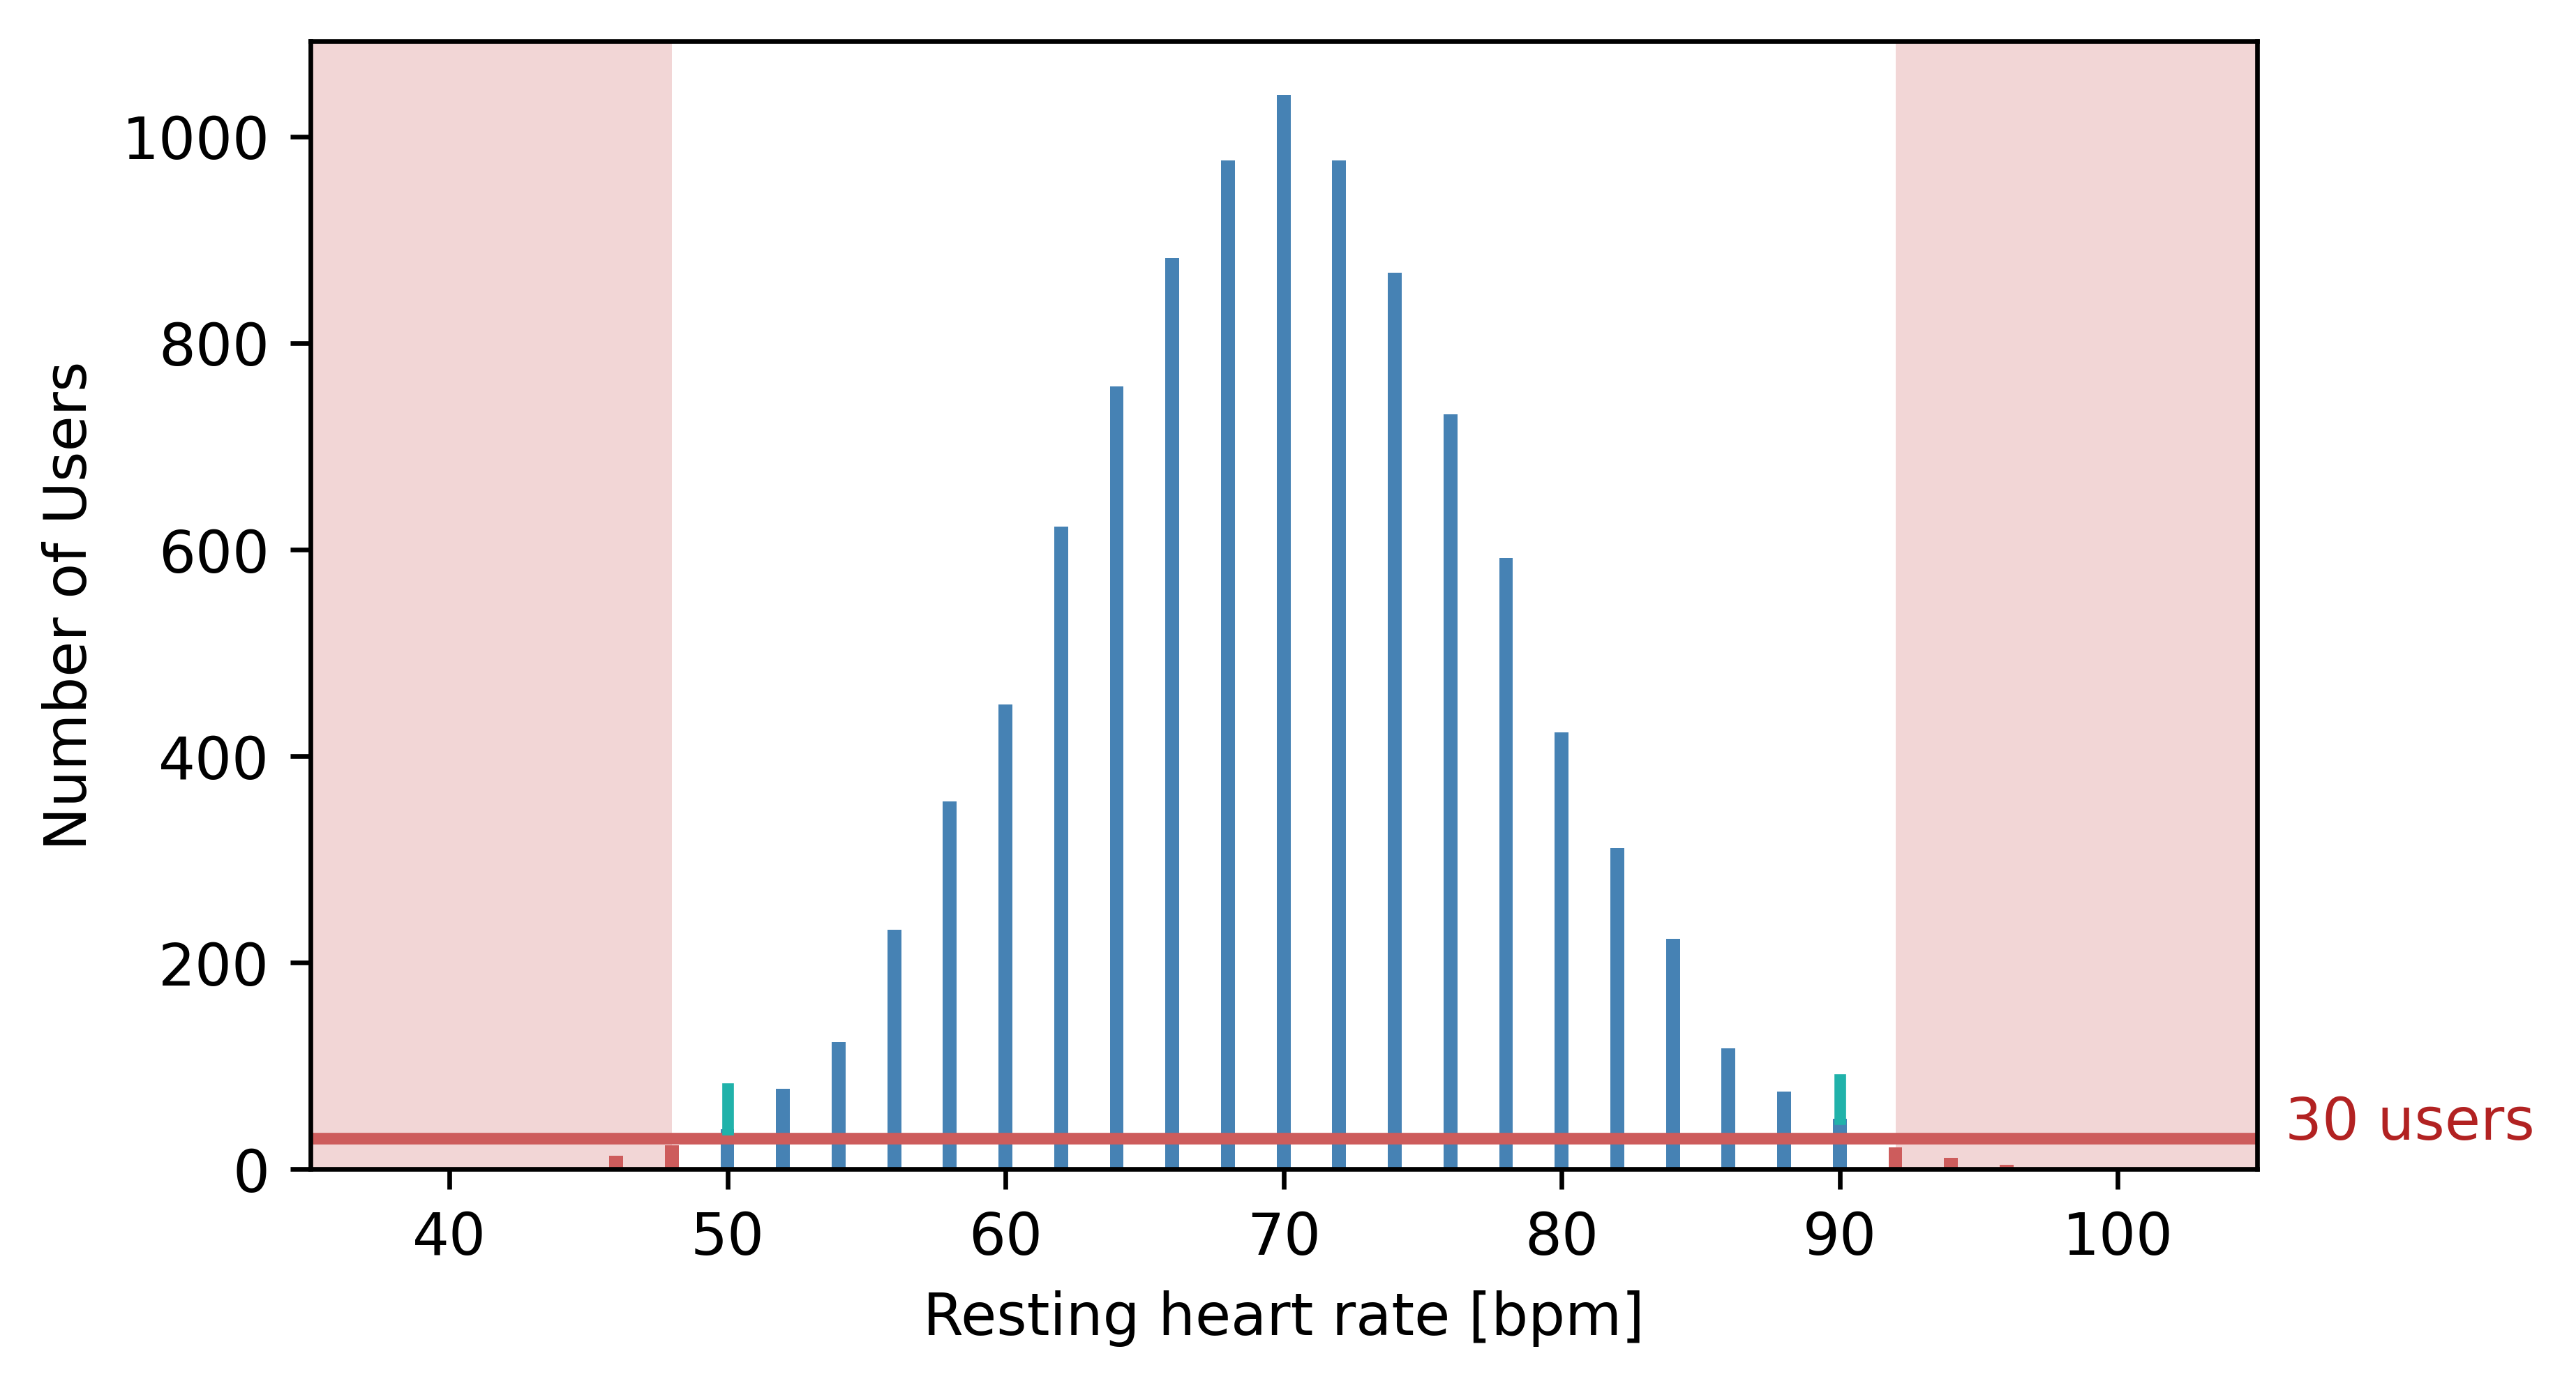

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=df_rounded_2["value"], height=df_rounded_2["count"], color=df_rounded_2["color"], width=0.5)
ax.set_xlim(left=35, right=105)
ax.set_xlabel("Resting heart rate [bpm]")
ax.set_ylabel("Number of Users")
plt.plot([35, 105], [min_bucket_size, min_bucket_size], linewidth=2, color="indianred")
ax.plot([left_cap_xlocation_2, left_cap_xlocation_2], [left_cap_ylocation_2, left_cap_ylocation_2+left_cap_size_2], linewidth=2, color="lightseagreen")
ax.plot([right_cap_xlocation_2, right_cap_xlocation_2], [right_cap_ylocation_2, right_cap_ylocation_2+right_cap_size_2], linewidth=2, color="lightseagreen")
ax.text(x=106, y=29, s=f"{min_bucket_size} users", color="firebrick")
ax.axvspan(0, last_left_red_2, facecolor='indianred', alpha=0.25)
ax.axvspan(first_right_red_2, 105, facecolor='indianred', alpha=0.25)
fig.savefig("histogram_2", bbox_inches="tight")

plt.show()

### Aggregation simulation

In [16]:
np.random.seed(0)
time = np.sort(np.random.uniform(low=0.5, high=7.5, size=42))
resting_heart_rate = np.round(np.random.normal(loc=65, scale=8, size=42), decimals=0).astype(int)

In [17]:
df_user = pd.DataFrame({"time":time, "resting_heart_rate":resting_heart_rate})
df_user.head()

,time,resting_heart_rate
0,0.631529,62
1,0.641529,66
2,0.997252,75
3,1.109905,75
4,1.327921,62


In [18]:
df_user.tail()

,time,resting_heart_rate
37,6.979176,66
38,7.106237,74
39,7.112682,55
40,7.245639,68
41,7.350328,60


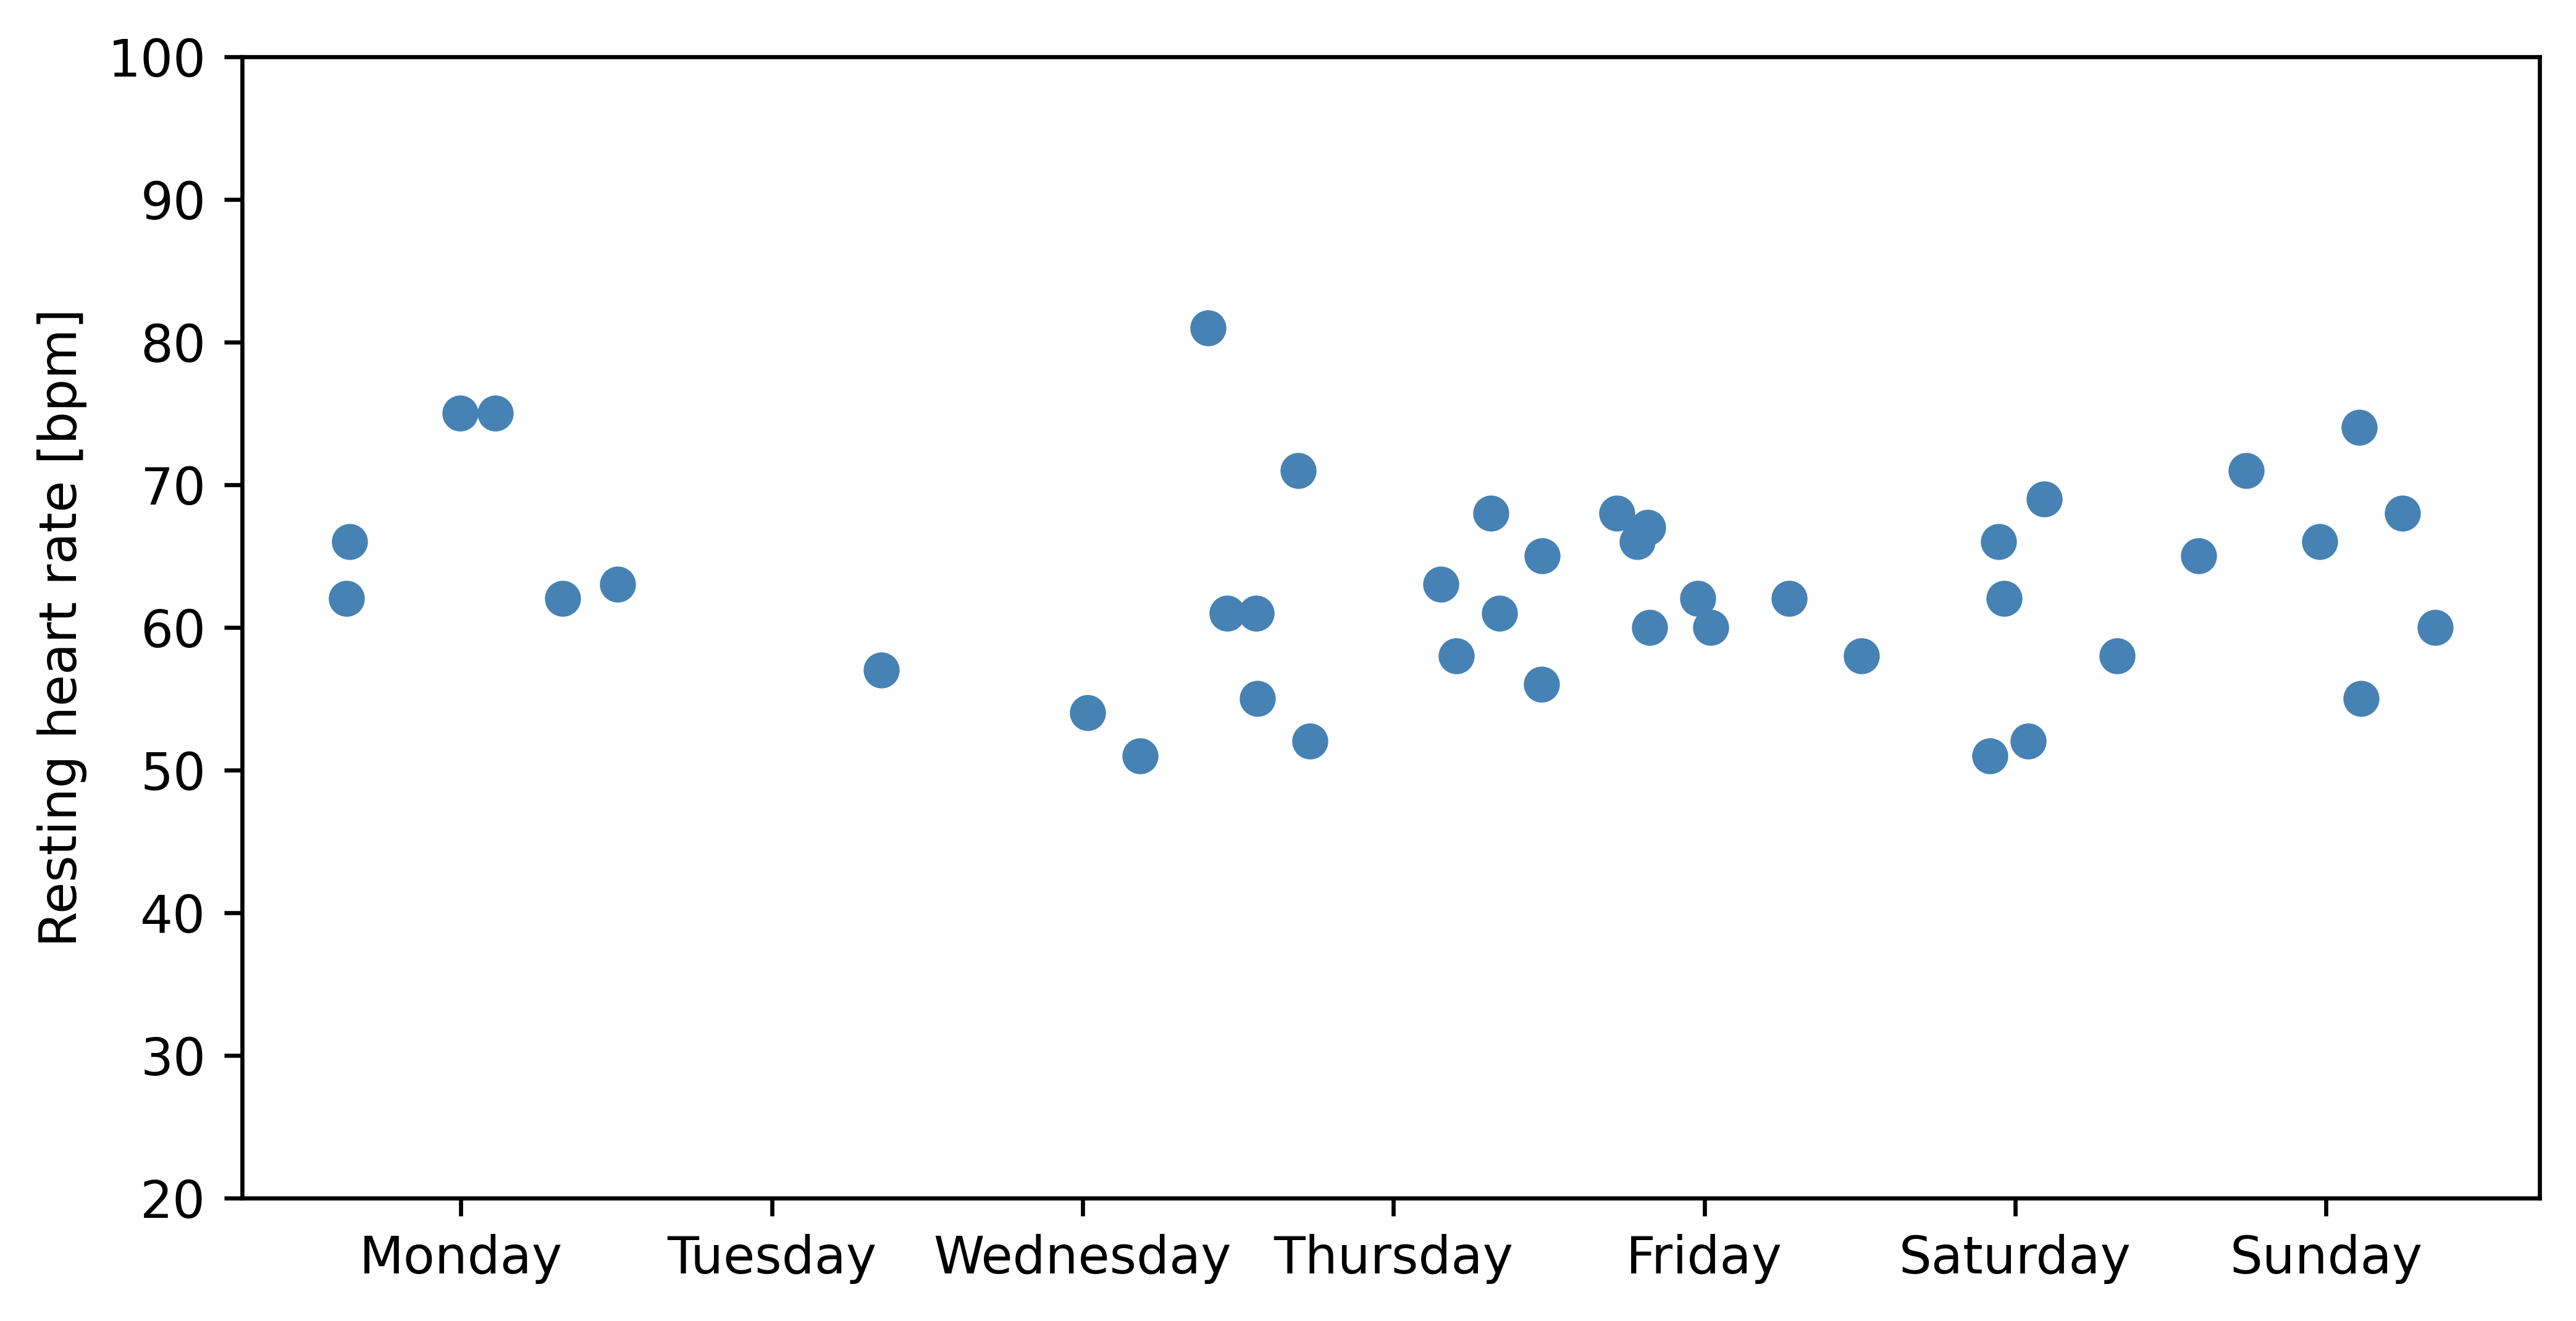

In [19]:
fig = plt.figure()
fig.set_size_inches(8, 4, forward=True)
ax = fig.add_subplot(111)
ax.scatter(x=df_user["time"], y=df_user["resting_heart_rate"], color="steelblue")
ax.set_ylim(bottom=20, top=100)
ax.set_ylabel("Resting heart rate [bpm]")
ax.set_xticks(ticks=range(1,8,1), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
fig.savefig("measurements", bbox_inches="tight")

plt.show()

In [20]:
df_user.describe()

,time,resting_heart_rate
count,42.000000,42.000000
mean,4.464091,62.785714
std,1.903040,6.937124
min,0.631529,51.000000
25%,3.488994,58.000000
50%,4.599191,62.000000
75%,5.959552,66.750000
max,7.350328,81.000000


In [21]:
df_user["resting_heart_rate"].value_counts()

62    5
66    4
60    3
68    3
58    3
61    3
55    2
65    2
52    2
71    2
51    2
63    2
75    2
81    1
54    1
57    1
56    1
67    1
69    1
74    1
Name: resting_heart_rate, dtype: int64